In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
users_df = pd.read_csv('./Data/user_data.csv')
users_df = users_df.drop(['country','contribution','follower_count','rating','max_rating','last_online_time_seconds','registration_time_seconds'], axis=1)
users_df["user_id"] = users_df["user_id"].str.replace("user_","").astype(int)
users_df = users_df.dropna()
users_df.head(5)

,user_id,submission_count,problem_solved,rank
0,3311,47,40,intermediate
1,3028,63,52,intermediate
2,2268,226,203,beginner
3,480,611,490,advanced
4,650,504,479,advanced


In [4]:
problems_df = pd.read_csv('./Data/problem_data.csv')
problems_df = problems_df.drop(['points'],axis=1)
problems_df = problems_df.dropna()
problems_df['tags'].fillna('Algorithms',inplace=True)
problems_df["problem_id"] = problems_df["problem_id"].str.replace("prob_","").astype(int)
problems_df.head()

,problem_id,level_type,tags
3,313,A,"greedy,implementation"
4,101,A,"constructive algorithms,greedy,math"
7,3059,B,brute force
10,4069,B,"dfs and similar,dsu,graphs"
11,4926,A,implementation


In [5]:
attempts_df = pd.read_csv('./Data/submissions.csv')
attempts_df = attempts_df.dropna()
attempts_df["user_id"] = attempts_df["user_id"].str.replace("user_","").astype(int)
attempts_df["problem_id"] = attempts_df["problem_id"].str.replace("prob_","").astype(int)
attempts_df.head(5)

,user_id,problem_id,attempts_range
0,232,6507,1
1,3568,2994,3
2,1600,5071,1
3,2256,703,1
4,2321,356,1


In [5]:
users_attempts_count_df = attempts_df.groupby(['user_id', 'problem_id']).size().groupby('user_id').size()
print('# users: %d' % len(users_attempts_count_df))
users_with_enough_attempts_df = users_attempts_count_df[users_attempts_count_df >= 5].reset_index()[['user_id']]
print('# users with at least 5 attempts: %d' % len(users_with_enough_attempts_df))

# users: 3529
# users with at least 5 attempts: 3413


In [6]:
print('# of attempts: %d' % len(attempts_df))
attempts_from_selected_users_df = attempts_df.merge(users_with_enough_attempts_df, 
               how = 'right',
               left_on = 'user_id',
               right_on = 'user_id')
print('# of problems from users with at least solved by 5 users: %d' % len(attempts_from_selected_users_df))
attempts_from_selected_users_df.head()

# of attempts: 155295
# of problems from users with at least solved by 5 users: 155008


,user_id,problem_id,attempts_range
0,232,6507,1
1,232,5781,1
2,232,137,2
3,232,1550,2
4,232,1322,3


In [7]:
def smooth_user_pref(z):
    return z
    
attempts_full_df = attempts_from_selected_users_df \
                    .groupby(['user_id', 'problem_id'])['attempts_range'].sum() \
                    .apply(smooth_user_pref).reset_index()
print('# of unique user/problem : %d' % len(attempts_full_df))
attempts_full_df.head(10)

# of unique user/problem : 155008


,user_id,problem_id,attempts_range
0,1,53,2
1,1,70,2
2,1,81,1
3,1,164,1
4,1,199,2
5,1,332,1
6,1,522,1
7,1,617,1
8,1,655,2
9,1,718,1


In [8]:
attempts_train_df, attempts_test_df = train_test_split(attempts_full_df,
                                   stratify=attempts_full_df['user_id'], 
                                   test_size=0.20,
                                   random_state=20)

print('# of problems solved on Train set: %d' % len(attempts_train_df))
print('# of problems solved on Test set: %d' % len(attempts_test_df))

# of problems solved on Train set: 124006
# of problems solved on Test set: 31002


In [9]:
attempts_full_indexed_df = attempts_full_df.set_index('user_id')
attempts_train_indexed_df = attempts_train_df.set_index('user_id')
attempts_test_indexed_df = attempts_test_df.set_index('user_id')

In [10]:
def get_problems_solved(user_id, attempts_df):
    solved_problems = attempts_df.loc[user_id]['problem_id']
    return set(solved_problems if type(solved_problems) == pd.Series else [solved_problems])

In [11]:
class ModelEvaluator:

    def get_not_solved_problems(self, user_id, sample_size, seed=20):
        problems_solved = get_problems_solved(user_id, attempts_full_indexed_df)
        all_problems = set(problems_df['problem_id'])
        non_solved_problems = all_problems - problems_solved

        random.seed(seed)
        non_solved_problems_sample = random.sample(non_solved_problems, sample_size)
        return set(non_solved_problems_sample)

    def verify(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, user_id):
        solved_testset = attempts_test_indexed_df.loc[user_id]
        if type(solved_testset['problem_id']) == pd.Series:
            user_solved_problems_testset = set(solved_testset['problem_id'])
        else:
            user_solved_problems_testset = set([int(solved_testset['problem_id'])])  
        solved_problems_count_testset = len(user_solved_problems_testset) 

        users_recs_df = model.recommend_problems(user_id, problems_to_ignore=get_problems_solved(user_id, 
                                                attempts_train_indexed_df), topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
  
        for prob_id in user_solved_problems_testset:
            non_solved_problems_sample = self.get_not_solved_problems(user_id,sample_size=100,seed=prob_id%(2**32))

            problems_to_filter_recs = non_solved_problems_sample.union(set([prob_id]))

            valid_recs_df = users_recs_df[users_recs_df['problem_id'].isin(problems_to_filter_recs)]                    
            valid_recs = valid_recs_df['problem_id'].values
            hit_at_5, index_at_5 = self.verify(prob_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self.verify(prob_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        recall_at_5 = hits_at_5_count / float(solved_problems_count_testset)
        recall_at_10 = hits_at_10_count / float(solved_problems_count_testset)

        user_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'solved': solved_problems_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return user_metrics

    def evaluate_model(self, model):
        users_metrics = []
        for ids, user_id in enumerate(list(attempts_test_indexed_df.index.unique().values)):
            user_metrics = self.evaluate_model_for_user(model, user_id)  
            user_metrics['_user_id'] = user_id
            users_metrics.append(user_metrics)
        print('%d users processed' % ids)

        detailed_result_df = pd.DataFrame(users_metrics).sort_values('solved', ascending=False)
        
        global_recall_at_5 = detailed_result_df['hits@5_count'].sum() / float(detailed_result_df['solved'].sum())
        global_recall_at_10 = detailed_result_df['hits@10_count'].sum() / float(detailed_result_df['solved'].sum())
        
        global_metrics = {'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_result_df
    
model_evaluator = ModelEvaluator()

# Content-Based Recommendation System

In [12]:
sw_list = stopwords.words('english')

vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.003, max_df=0.5, max_features=5000,stop_words=sw_list)

problem_ids = problems_df['problem_id'].tolist()
tfidf_matrix = vectorizer.fit_transform(problems_df['tags'] + "" + problems_df['level_type'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3027x231 sparse matrix of type '<class 'numpy.float64'>'
	with 12564 stored elements in Compressed Sparse Row format>

In [13]:
def get_problem_profile(prob_id):
    idx = problem_ids.index(prob_id)
    problem_profile = tfidf_matrix[idx:idx+1]
    return problem_profile

def get_problem_profiles(ids):
    if isinstance(ids, np.int64):
        problem_profiles_list = get_problem_profile(ids)
    else:
        problem_profiles_list = [get_problem_profile(x) for x in ids]
    problem_profiles = scipy.sparse.vstack(problem_profiles_list)
    return problem_profiles

def build_users_profile(user_id, attempts_indexed_df):
    attempts_user_df = attempts_indexed_df.loc[user_id]
    user_problem_profiles = get_problem_profiles(attempts_user_df['problem_id'])
    user_problem_strengths = np.array(attempts_user_df['attempts_range']).reshape(-1,1)

    user_problem_strengths_weighted_avg = np.sum(user_problem_profiles.multiply(user_problem_strengths), axis=0) / np.sum(user_problem_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_problem_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    attempts_indexed_df = attempts_train_df[attempts_train_df['problem_id'].isin(problems_df['problem_id'])].set_index('user_id')
    user_profiles = {}

    for user_id in attempts_indexed_df.index.unique():
        user_profiles[user_id] = build_users_profile(user_id, attempts_indexed_df)
    return user_profiles

In [14]:
user_profiles = build_users_profiles()
len(user_profiles)

3413

In [15]:
testUserProfile = user_profiles[2605]
print(testUserProfile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names,user_profiles[2605].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 231)


,token,relevance
0,implementationa,0.383393
1,constructive,0.257127
2,dpc,0.240155
3,algorithms,0.238762
4,constructive algorithms,0.238762
5,brute force,0.214392
6,force,0.214392
7,brute,0.205536
8,dfs,0.190561
9,implementationb,0.183985


In [16]:
class ContentBasedRecommender:
    
    def __init__(self, problems_df=None):
        self.problem_ids = problem_ids
        self.problems_df = problems_df
        
    def get_same_problems_to_user_profile(self, user_id, topn=1000):
        cosine = cosine_similarity(user_profiles[user_id], tfidf_matrix)
        same_indices = cosine.argsort().flatten()[-topn:]
        same_problems = sorted([(problem_ids[i], cosine[0,i]) for i in same_indices], key=lambda x: -x[1])
        return same_problems
        
    def recommend_problems(self, user_id, problems_to_ignore=[], topn=10, rec=False):
        same_problems = self.get_same_problems_to_user_profile(user_id)
        same_problems_filtered = list(filter(lambda x: x[0] not in problems_to_ignore, same_problems))
        
        recommendations_df = pd.DataFrame(same_problems_filtered, columns=['problem_id', 'Attempts']).head(topn)

        if rec:
            recommendations_df = recommendations_df.merge(self.problems_df, how = 'left',left_on = 'problem_id', 
                                                          right_on = 'problem_id')[['Attempts', 'problem_id', 'tags', 'level_type']]

        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(problems_df)

In [17]:
print('Evaluating Content-Based Filtering model...')
content_metrics, content_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nContent Based Recommendation metrics:\n%s' % content_metrics)

Evaluating Content-Based Filtering model...
3412 users processed

Content Based Recommendation metrics:
{'recall@5': 0.10302561125088704, 'recall@10': 0.18866524740339333}


# Collaborative Filtering Recommendation System

In [18]:
users_problems_pivot_matrix_df = attempts_train_df.pivot(index='user_id',columns='problem_id',values='attempts_range').fillna(0)
users_problems_pivot_matrix_df.head(10)

problem_id,1,2,3,4,5,6,7,9,10,11,...,6534,6536,6537,6538,6539,6540,6541,6542,6543,6544
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
users_problems_pivot_matrix = users_problems_pivot_matrix_df.as_matrix()
users_problems_pivot_matrix[:10]

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
users_ids = list(users_problems_pivot_matrix_df.index)

In [30]:
user_attempts_mean = np.mean(users_problems_pivot_matrix, axis = 1)
R_demeaned = users_problems_pivot_matrix - user_attempts_mean.reshape(-1, 1)

In [31]:
U, sigma, Vt = svds(R_demeaned, k = 50)

In [32]:
U.shape

(3413, 50)

In [33]:
Vt.shape

(50, 5497)

In [34]:
sigma = np.diag(sigma)
sigma.shape

(50, 50)

In [35]:
all_user_predicted_attempts = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_attempts

array([[-1.25277044e-02, -1.08023157e-02,  1.19522413e-01, ...,
        -1.50804505e-02,  7.10171127e-04, -1.20155740e-02],
       [-1.94488805e-02, -2.09548760e-02, -1.24274193e-01, ...,
        -1.20185340e-02, -1.37753807e-02, -2.11504564e-02],
       [-1.44010078e-02, -1.20119581e-02,  1.04895701e-01, ...,
         1.10967958e-05, -1.66961054e-02, -1.51481036e-02],
       ...,
       [-3.32230815e-03, -3.89434903e-03, -2.19018382e-02, ...,
        -4.28318643e-03, -4.87275056e-03, -4.42206475e-03],
       [-1.46924459e-02, -1.41476939e-02, -3.31702198e-02, ...,
        -2.02673616e-02, -1.30869644e-02, -1.59120158e-02],
       [-1.18971993e-02, -1.11096108e-02,  1.44954659e-01, ...,
        -8.43501565e-03, -8.21226954e-03, -1.16745874e-02]])

In [36]:
all_user_predicted_attempts_norm = (all_user_predicted_attempts - all_user_predicted_attempts.min()) / (all_user_predicted_attempts.max() - all_user_predicted_attempts.min())

In [38]:
cf_preds_df = pd.DataFrame(all_user_predicted_attempts_norm, columns = users_problems_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,1,2,3,4,5,6,7,8,9,10,...,3562,3563,3564,3565,3566,3567,3568,3569,3570,3571
problem_id,,,,,,,,,,,,,,,,,,,,,
1,0.179283,0.178418,0.179049,0.180281,0.179717,0.178834,0.179363,0.178923,0.180007,0.179524,...,0.179146,0.179440,0.180233,0.180274,0.180461,0.179113,0.178579,0.180434,0.179013,0.179362
2,0.179499,0.178230,0.179348,0.179968,0.179941,0.178864,0.179423,0.178885,0.180635,0.179508,...,0.179304,0.179327,0.179920,0.179964,0.180391,0.178869,0.178256,0.180363,0.179081,0.179461
3,0.195790,0.165315,0.193961,0.179959,0.174002,0.171383,0.177431,0.178882,0.190828,0.167390,...,0.159425,0.179475,0.177253,0.173205,0.180287,0.181434,0.171903,0.178112,0.176703,0.198969
4,0.181075,0.176097,0.198887,0.179909,0.181174,0.177601,0.180708,0.183126,0.180925,0.179892,...,0.179019,0.178351,0.178916,0.178940,0.180420,0.181246,0.180491,0.180691,0.176806,0.181436
5,0.180968,0.183693,0.180598,0.180514,0.179889,0.177332,0.180529,0.180929,0.178849,0.179076,...,0.178306,0.180992,0.179768,0.181329,0.181277,0.179692,0.180607,0.181721,0.177663,0.179167
6,0.179898,0.178833,0.179994,0.180288,0.181244,0.177934,0.179807,0.177374,0.180253,0.180344,...,0.177949,0.177910,0.180377,0.179983,0.180860,0.178998,0.178324,0.180423,0.178428,0.178941
7,0.179080,0.177485,0.179889,0.179883,0.179293,0.179343,0.179950,0.177960,0.180213,0.180022,...,0.179203,0.178895,0.180063,0.179909,0.180116,0.178682,0.179006,0.181130,0.179378,0.179125
9,0.179470,0.180220,0.178113,0.181249,0.179964,0.179043,0.178945,0.177527,0.180885,0.179099,...,0.177464,0.179880,0.181932,0.178470,0.181263,0.179539,0.178569,0.180015,0.180130,0.179423
10,0.180667,0.177815,0.177922,0.180756,0.181804,0.176092,0.181619,0.178541,0.184268,0.180762,...,0.178724,0.179963,0.178322,0.180759,0.180457,0.177943,0.176253,0.180606,0.178382,0.182062


In [39]:
len(cf_preds_df.columns)

3413

In [40]:
class CollaborativeFilteringRecommender:
    
    def __init__(self, cf_predictions_df, problems_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.problems_df = problems_df
        
    def recommend_problems(self, user_id, problems_to_ignore=[], topn=10, rec=False): 
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'Attempts'})

        recommendations_df = sorted_user_predictions[~sorted_user_predictions['problem_id'].isin(problems_to_ignore)] \
                               .sort_values('Attempts', ascending = False).head(topn)

        if rec:
            recommendations_df = recommendations_df.merge(self.problems_df, how = 'left',left_on = 'problem_id', 
                                                          right_on = 'problem_id')[['Attempts', 'problem_id', 'tags', 'level_type']]

        return recommendations_df
    
collaborative_filtering_recommender_model = CollaborativeFilteringRecommender(cf_preds_df, problems_df)

In [41]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
collaborative_metrics, collaborative_results_df = model_evaluator.evaluate_model(collaborative_filtering_recommender_model)
print('\nCollaborative Filtering recommendation metrics:\n%s' % collaborative_metrics)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
3412 users processed

Collaborative Filtering recommendation metrics:
{'recall@5': 0.5491258628475583, 'recall@10': 0.6596348622669506}


# Hybrid Recommendation System

In [42]:
class HybridRecommender:
    
    def __init__(self, cb_model, cf_model, problems_df, cb_weight=1.0, cf_weight=1.0):
        self.cb_model = cb_model
        self.cf_model = cf_model
        self.cb_weight = cb_weight
        self.cf_weight = cf_weight
        self.problems_df = problems_df
        
    def recommend_problems(self, user_id, problems_to_ignore=[], topn=10, rec=False):
        cb_recs_df = self.cb_model.recommend_problems(user_id, problems_to_ignore=problems_to_ignore, rec=rec,
                                                           topn=1000).rename(columns={'Attempts': 'AttemptsCB'})
        
        cf_recs_df = self.cf_model.recommend_problems(user_id, problems_to_ignore=problems_to_ignore, rec=rec, 
                                                           topn=1000).rename(columns={'Attempts': 'AttemptsCF'})
        
        recs_df = cb_recs_df.merge(cf_recs_df,how = 'outer',left_on = 'problem_id', right_on = 'problem_id').fillna(0.0)  
        recs_df['AttemptsHybrid'] = (recs_df['AttemptsCB'] * self.cb_weight)+ (recs_df['AttemptsCF'] * self.cf_weight)   
        recommendations_df = recs_df.sort_values('AttemptsHybrid', ascending=False).head(topn)

        if rec:
            recommendations_df = recommendations_df.merge(self.problems_df, how = 'left',left_on = 'problem_id', 
                                                          right_on = 'problem_id')[['AttemptsHybrid', 'problem_id', 'tags', 'level_type']]

        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, collaborative_filtering_recommender_model, 
                                             problems_df,cb_weight=1.0, cf_weight=100.0)

In [43]:
print('Evaluating Hybrid model...')
hybrid_metrics, hybrid_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nHybrid recommendation metrics:\n%s' % hybrid_metrics)

Evaluating Hybrid model...
3412 users processed

Hybrid recommendation metrics:
{'recall@5': 0.5509967098896845, 'recall@10': 0.6572801754725501}


# Comapring Models

In [44]:
metrics_df = pd.DataFrame([content_metrics, collaborative_metrics, hybrid_metrics])
metrics_df = metrics_df.set_index([pd.Index(['Content-Based Recommendation','Collaborative Filtering Recommendation','Hybrid Recoomendation'])])
metrics_df

,recall@5,recall@10
Content-Based Recommendation,0.103026,0.188665
Collaborative Filtering Recommendation,0.549126,0.659635
Hybrid Recoomendation,0.550997,0.657280


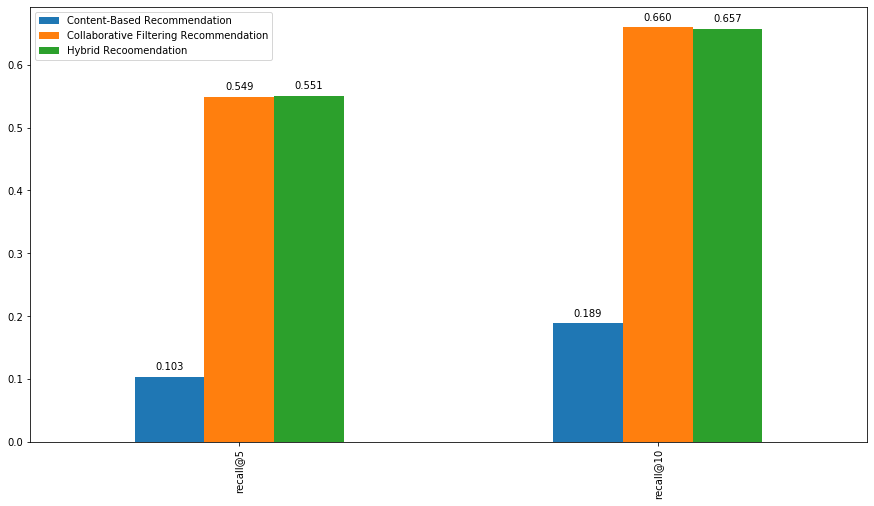

In [45]:
%matplotlib inline
ax = metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [46]:
def solved_problems(user_id, test=True):
    if test:
        attempts_df = attempts_test_indexed_df
    else:
        attempts_df = attempts_train_indexed_df
    return attempts_df.loc[user_id].merge(problems_df, how = 'left',left_on = 'problem_id',right_on = 'problem_id') \
                          .sort_values('attempts_range', ascending = False)[['attempts_range', 'problem_id','tags', 'level_type']]

In [47]:
solved_problems(2605, test=False).head(20)

,attempts_range,problem_id,tags,level_type
46,6,1929,"binary search,constructive algorithms,graphs,s...",B
30,5,5157,dp,C
1,3,3155,"greedy,hashing,implementation,math,number theory",C
19,3,1334,dfs and similar,B
20,3,6049,"brute force,data structures,implementation",A
33,3,275,"brute force,constructive algorithms,implementa...",C
43,2,6407,implementation,B
40,2,5480,"2-sat,dfs and similar,dsu,graphs",D
10,2,1891,NaN,NaN
11,2,6099,"dp,greedy",B


In [48]:
hybrid_recommender_model.recommend_problems(2605, topn=20, rec=True)

,AttemptsHybrid,problem_id,tags,level_type
0,42.971977,1675,"greedy,math,number theory",B
1,39.062516,53,"binary search,data structures,math",C
2,32.098524,5071,implementation,A
3,30.764772,3334,number theory,B
4,25.521144,4380,"binary search,math",C
5,24.425092,4598,"constructive algorithms,dfs and similar,divide...",B
6,24.365163,1279,"binary search,dp,implementation,two pointers",C
7,24.291744,5206,"constructive algorithms,sortings",A
8,24.254037,114,greedy,A
9,24.131333,4489,constructive algorithms,B
